In [ ]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K

'''
Dataset: Particles
Dataset: Particles_Classes
Dataset: Particles_Names

array([b'MET_class_1', b'Four_Ele_class_2', b'Four_Mu_class_3',
       b'Ten_Jet_class_4'], dtype='|S16')
       
array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')

shape = (n, 19, 4)
'''

files = ['background_for_training.h5',
         'Ato4l_lepFilter_13TeV_filtered.h5',
         'hChToTauNu_13TeV_PU20_filtered.h5',
         'hToTauTau_13TeV_PU20_filtered.h5',
         'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

data = []
for i in range(len(files)):
    with h5py.File(files[i], 'r') as hdf:
        if i == 0:
            data.append(hdf['Particles'][:80000])
        else:
            data.append(hdf['Particles'][:])
    print(data[i].shape)

(80000, 19, 4)
(55969, 19, 4)
(760272, 19, 4)
(691283, 19, 4)
(340544, 19, 4)


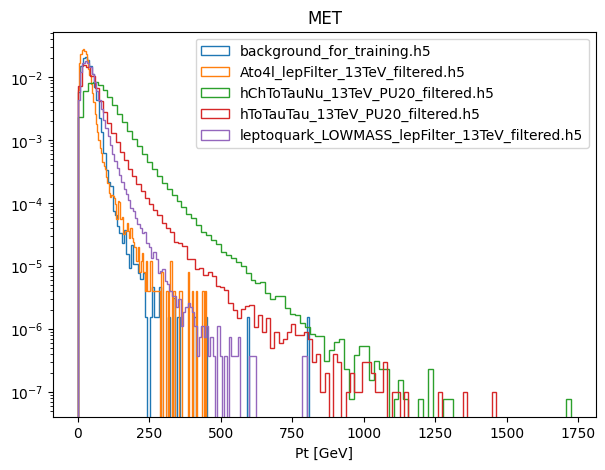

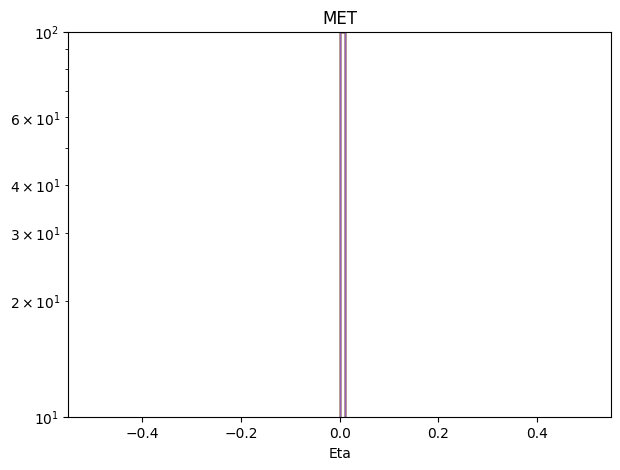

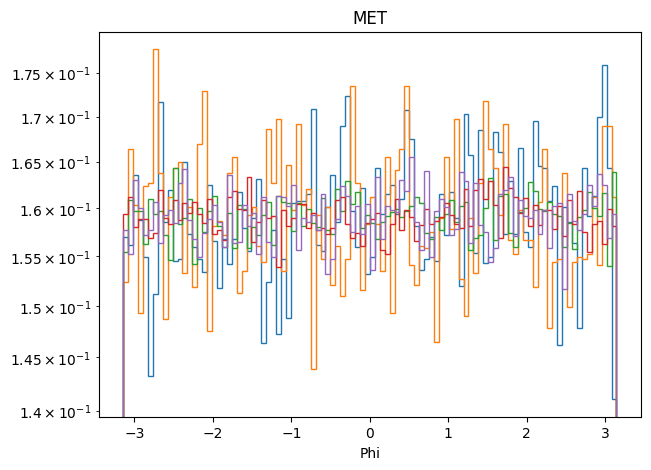

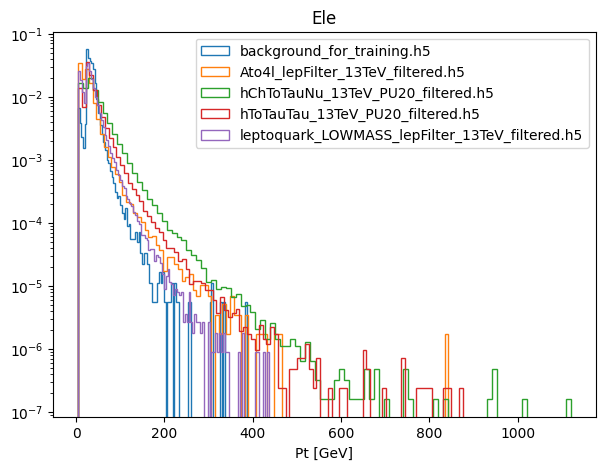

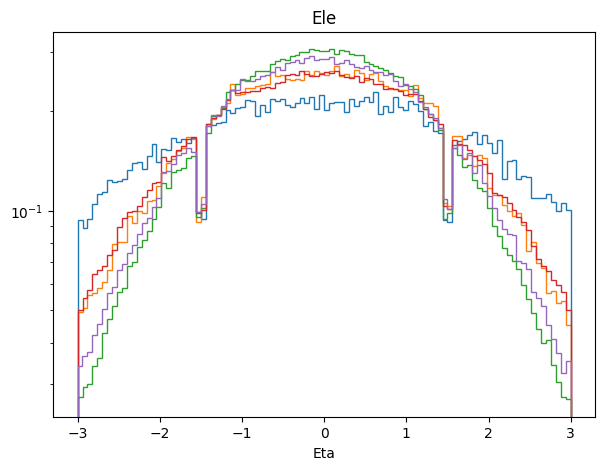

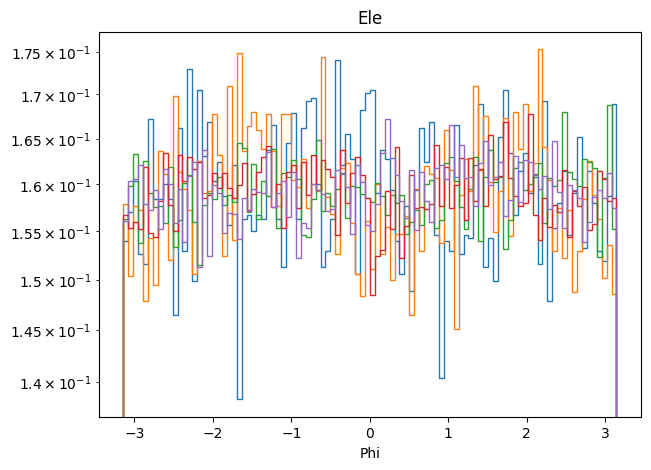

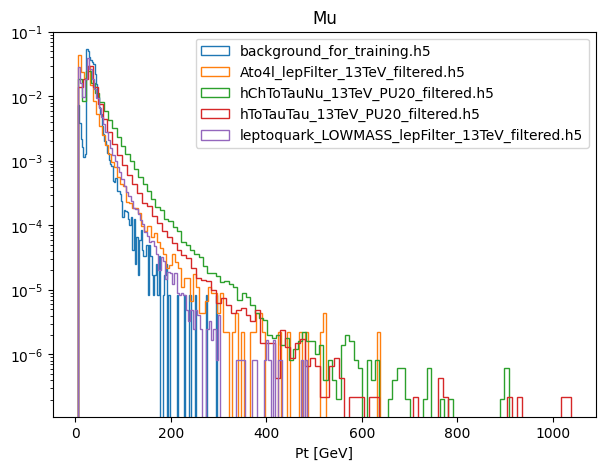

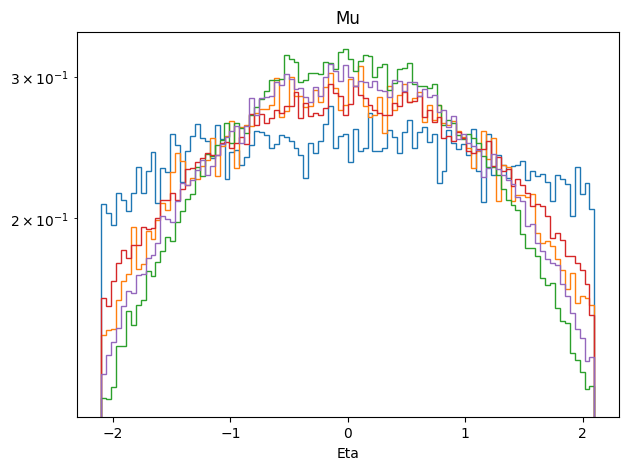

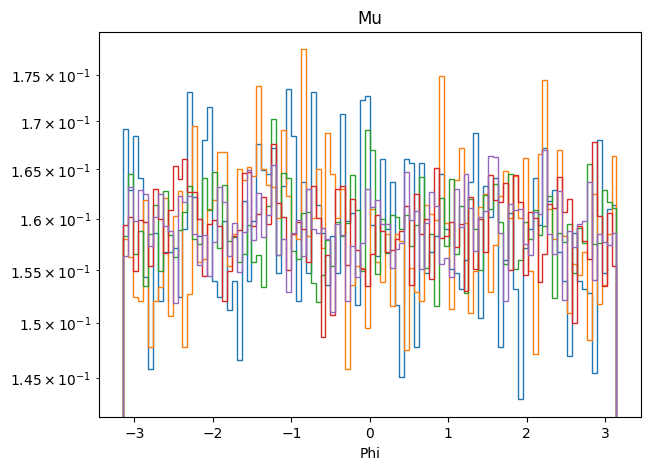

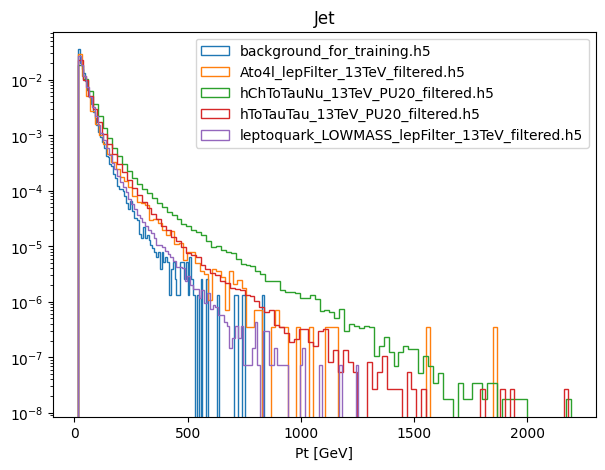

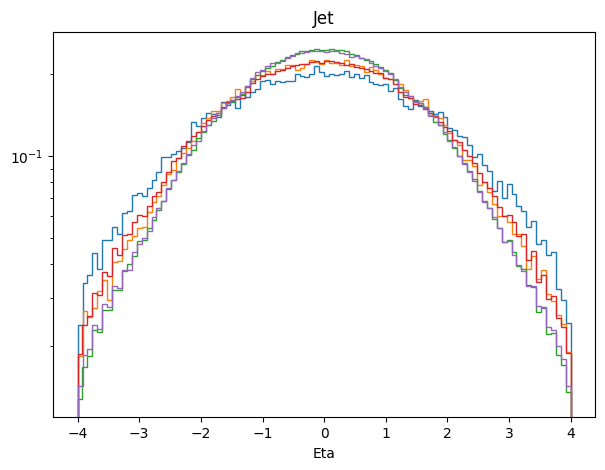

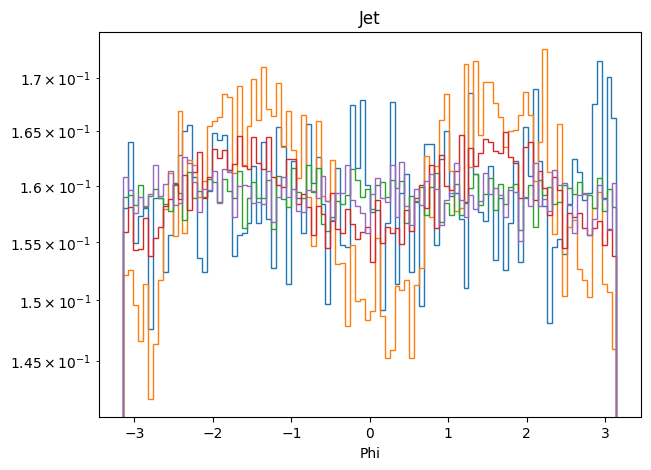

In [9]:
def plot_data(data, obj):
    if obj == 'MET':
        k = 1
    elif obj == 'Ele':
        k = 2
    elif obj == 'Mu':
        k = 3
    elif obj == 'Jet':
        k = 4

    plt.figure(figsize=(7,5))

    for i in range(len(data)):
        plt.hist(data[i][:,:,0][data[i][:,:,3]==k], log=True, label=files[i], alpha=1, histtype='step',
                 density=True, bins=100)
        plt.xlabel('Pt [GeV]')
        plt.title(obj)
        plt.legend()
    plt.show()
    
    plt.figure(figsize=(7,5))
    for i in range(len(data)):
        plt.hist(data[i][:,:,1][data[i][:,:,3]==k], log=True, label=files[i], alpha=1, histtype='step',
                 density=True, bins=100)
        plt.xlabel('Eta')
        plt.title(obj)
        #plt.legend()
    plt.show()
    
    plt.figure(figsize=(7,5))
    for i in range(len(data)):
        plt.hist(data[i][:,:,2][data[i][:,:,3]==k], log=True, label=files[i], alpha=1, histtype='step',
                 density=True, bins=100)
        plt.xlabel('Phi')
        plt.title(obj)
        #plt.legend()
    plt.show()
    
plot_data(data, 'MET')
plot_data(data, 'Ele')
plot_data(data, 'Mu')
plot_data(data, 'Jet')